In [ ]:
!pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import json

In [ ]:
# Define constants
RANDOM_STATE=42
FOLDS=3
TEST_INSTANCE_IDX=5

# Model


### Load data

In [ ]:
# Load diabetes data
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Human Machine Interaction/diabetes.csv')

# Print dataset stats
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

### Data Cleaning
Some features present values equals to 0 which is impossible (Glucose, BloodPressure ...). Substitute these values with the mean.

In [ ]:
def checkZeroAndReplaceWithNaN(df, cols):
  for col in cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

    df[col].replace(0, np.nan, inplace=True)
    zerosFound = df[col].isna().sum()
    print(f"Found {zerosFound} zeros in column {col}")

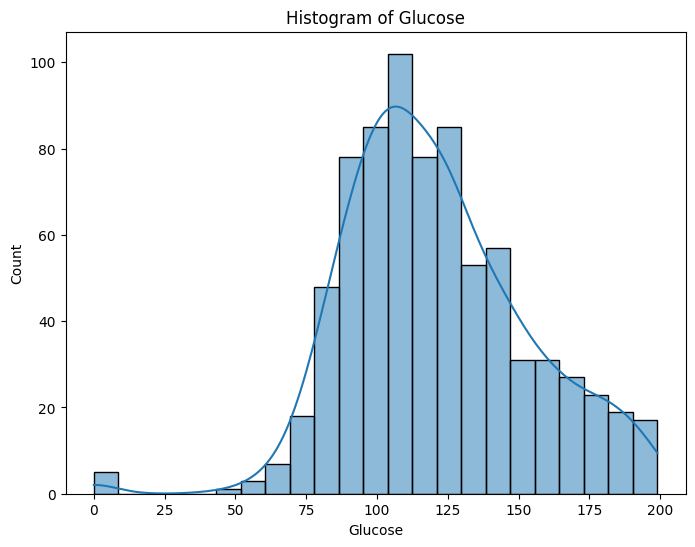

Found 5 zeros in column Glucose


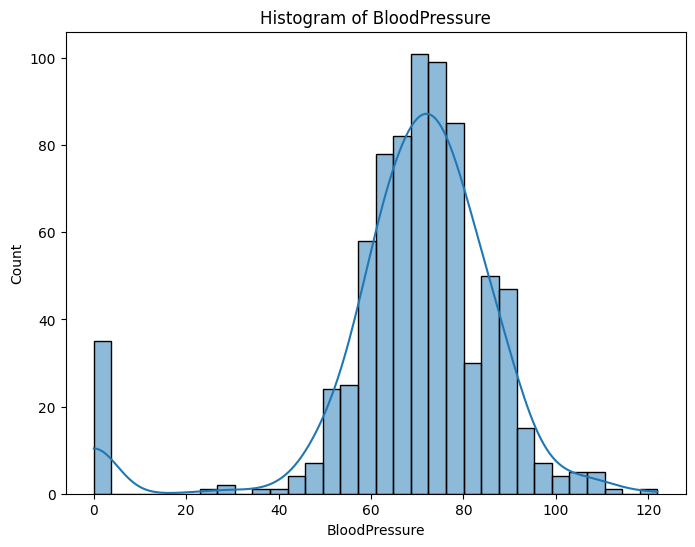

Found 35 zeros in column BloodPressure


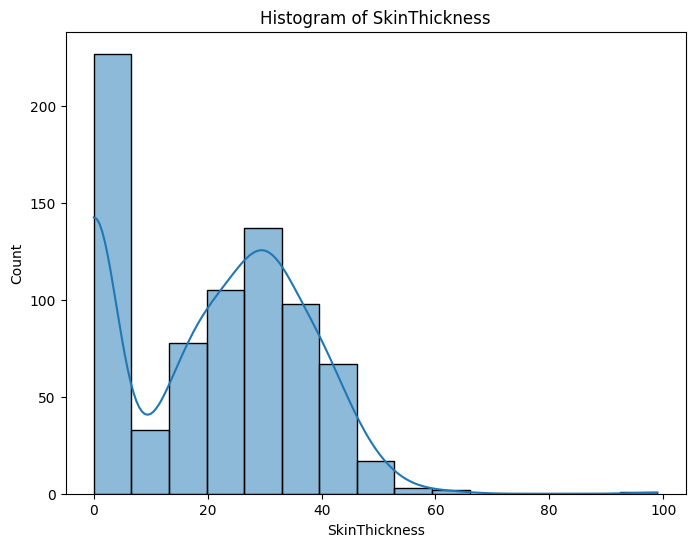

Found 227 zeros in column SkinThickness


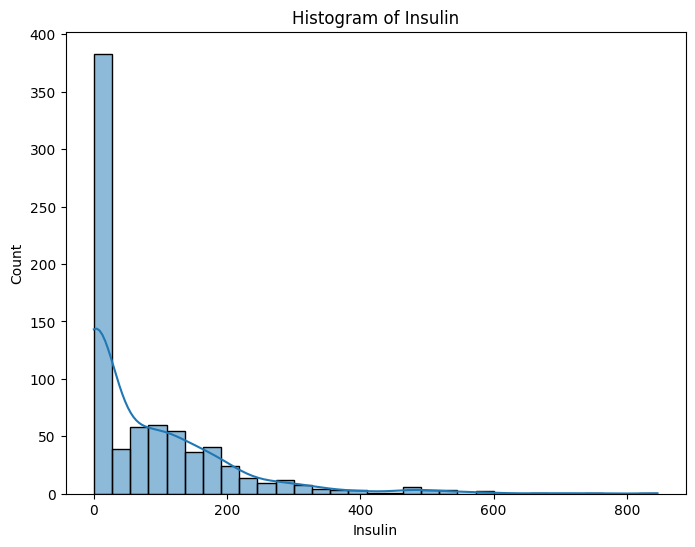

Found 374 zeros in column Insulin


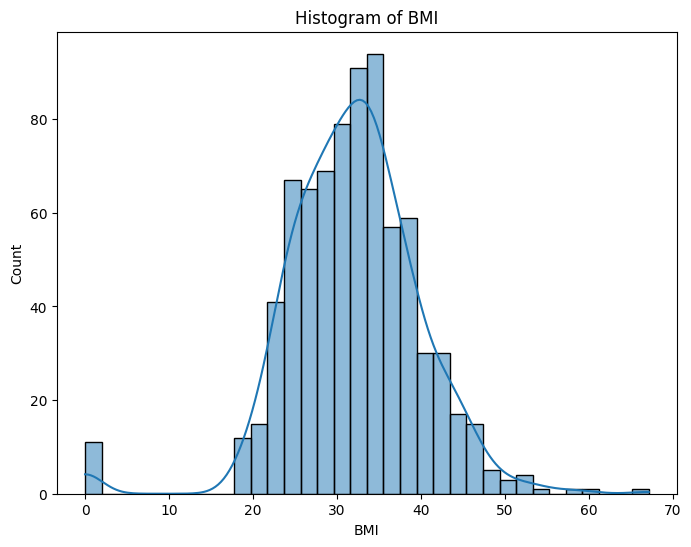

Found 11 zeros in column BMI


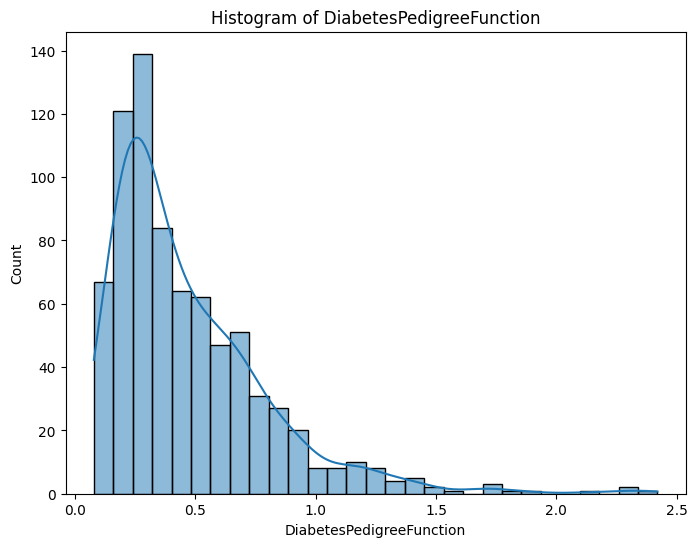

Found 0 zeros in column DiabetesPedigreeFunction


In [ ]:
cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction"]
checkZeroAndReplaceWithNaN(df, cols)

In [ ]:
df.fillna(df.mean(), inplace=True)
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.686763      72.405184      29.153420  155.548223   
std       3.369578   30.435949      12.096346       8.790942   85.021108   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.202592      29.153420  155.548223   
75%       6.000000  140.250000      80.000000      32.000000  155.548223   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.457464                  0.471876   33.240885    0.348958  
std      6.875151                  0.331329   11.760232    0.476951  
min     18.200000                  

### Remove outliers

In [ ]:
cols = df.columns[:-1].tolist()

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

outliers = (df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))

In [ ]:
df[outliers.any(axis=1)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1
8,2,197.0,70.0,45.00000,543.000000,30.5,0.158,53,1
12,10,139.0,80.0,29.15342,155.548223,27.1,1.441,57,0
13,1,189.0,60.0,23.00000,846.000000,30.1,0.398,59,1
16,0,118.0,84.0,47.00000,230.000000,45.8,0.551,31,1
...,...,...,...,...,...,...,...,...,...
718,1,108.0,60.0,46.00000,178.000000,35.5,0.415,24,0
747,1,81.0,74.0,41.00000,57.000000,46.3,1.096,32,0
753,0,181.0,88.0,44.00000,510.000000,43.3,0.222,26,1
760,2,88.0,58.0,26.00000,16.000000,28.4,0.766,22,0


Found 253 instances containing at least 1 outlier

In [ ]:
# Remove outliers
df = df[~outliers.any(axis=1)]

In [ ]:
# Count outcome values
df['Outcome'].value_counts()

Outcome
0    336
1    179
Name: count, dtype: int64

### Correlation analysis

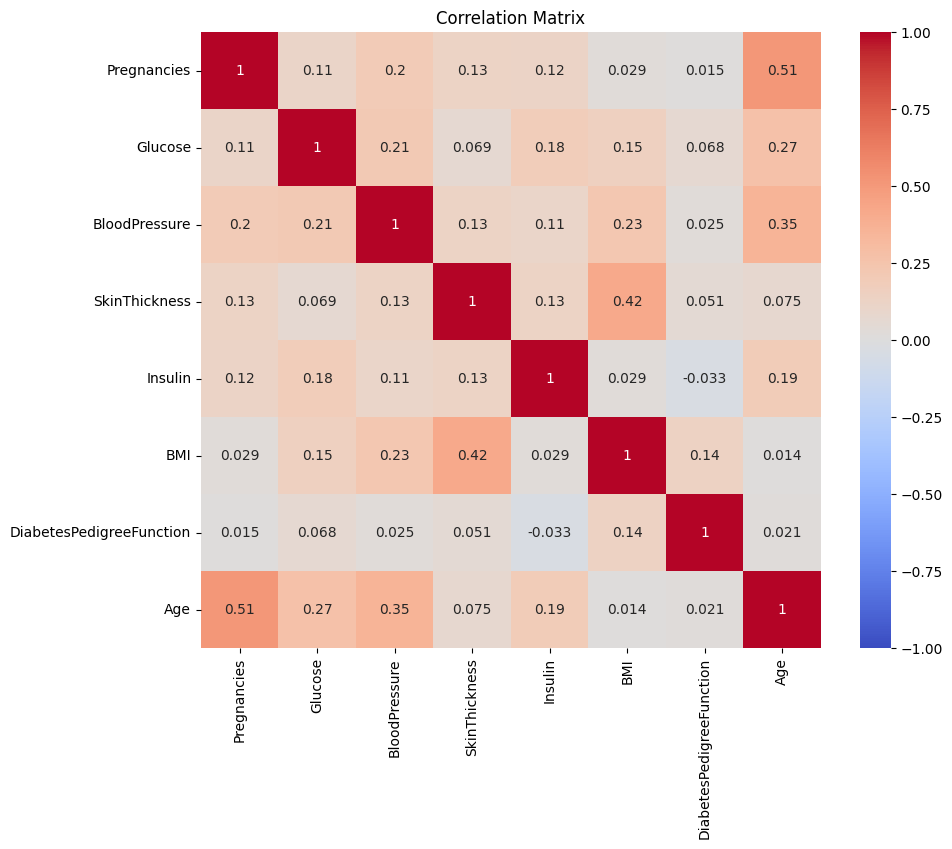

In [ ]:
corr = df[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

### Split the data

In [ ]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Fit XGBoost model

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Evaluation

In [ ]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81        63
           1       0.75      0.53      0.62        40

    accuracy                           0.75       103
   macro avg       0.75      0.71      0.71       103
weighted avg       0.75      0.75      0.74       103



In [ ]:
def dispConfMatrix(y_test, y_pred):
  conf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt='d')
  plt.title('Confusion matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

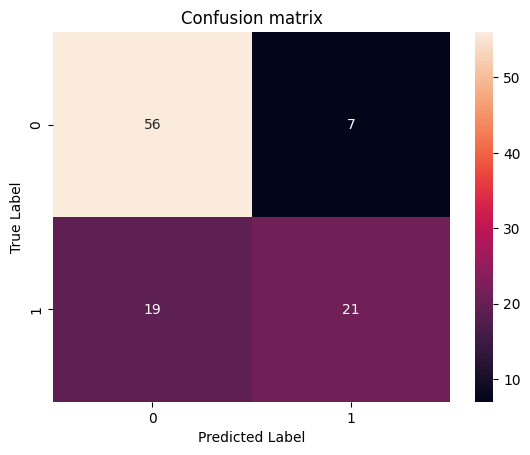

In [ ]:
dispConfMatrix(y_test, y_pred)

### Fine tune the model

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

base_xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
grid_search = GridSearchCV(estimator=base_xgb_model, param_grid=param_grid, cv=FOLDS, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [ ]:
print(f'Best parameters found: {grid_search.best_params_}')

Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
best_xgb_model = grid_search.best_estimator_
y_pred_best = best_xgb_model.predict(X_test)

In [ ]:
y_pred = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80        63
           1       0.70      0.57      0.63        40

    accuracy                           0.74       103
   macro avg       0.73      0.71      0.71       103
weighted avg       0.73      0.74      0.73       103



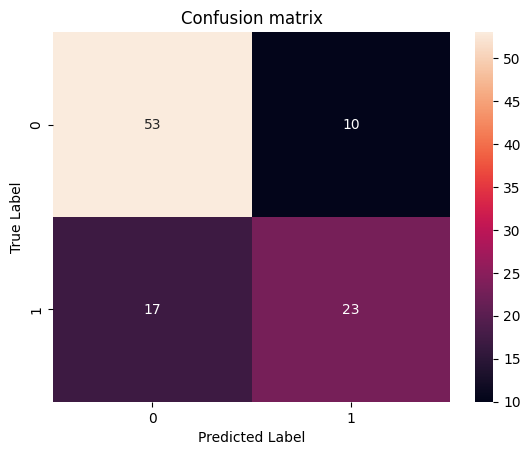

In [ ]:
dispConfMatrix(y_test, y_pred)

### Save the model

In [ ]:
joblib.dump(best_xgb_model, "model.joblib")

['model.joblib']

# SHAP

In [ ]:
# Calculate Shapley values using the SHAP library
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_test)

### Display feature importance


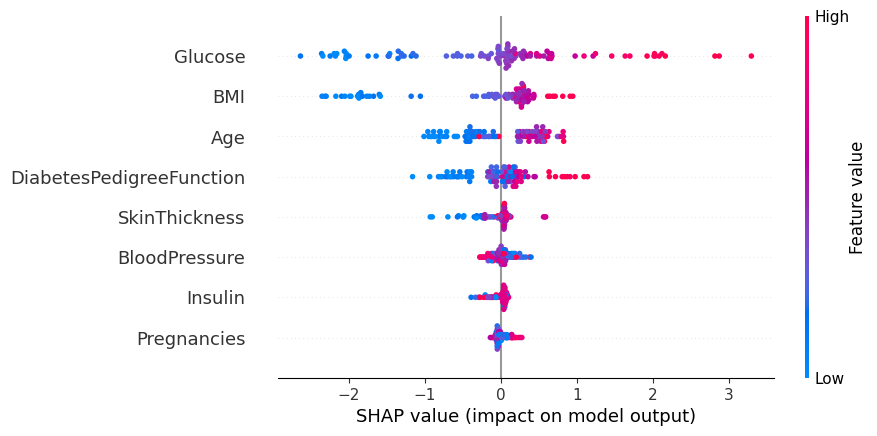

In [ ]:
shap.plots.beeswarm(shap_values)

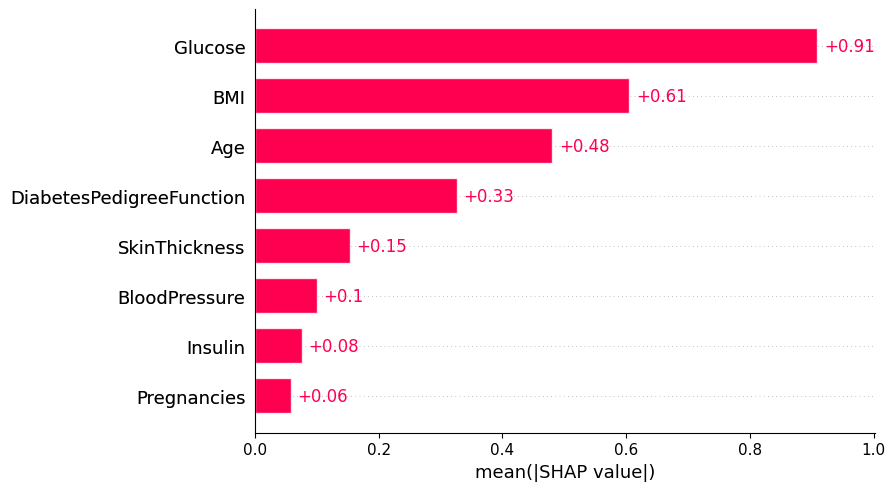

In [ ]:
shap.plots.bar(shap_values)

### Display the contribution graph for a single instance

Prediction for instance 5: 61.12%


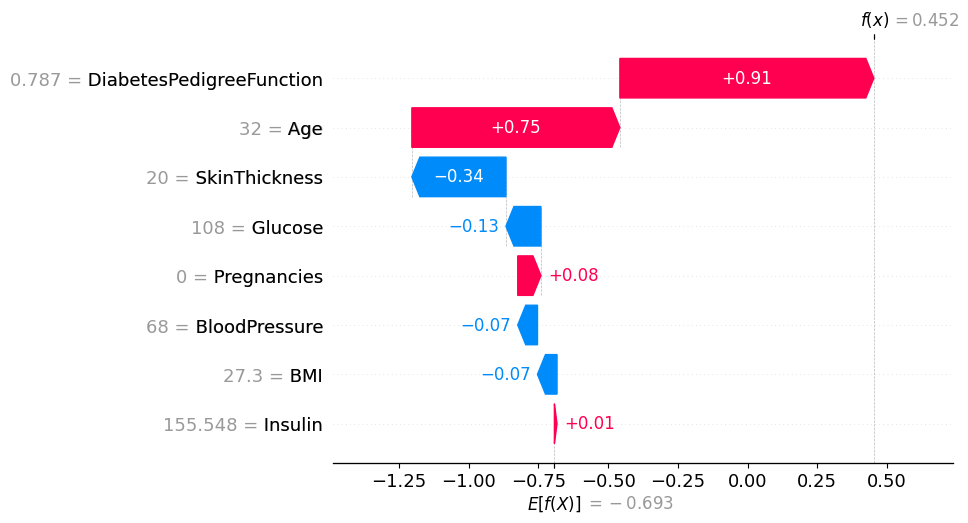

In [ ]:
test_instance = X_test[TEST_INSTANCE_IDX:TEST_INSTANCE_IDX+1]

test_instance_pred = best_xgb_model.predict_proba(test_instance)[0][1] # take probability of class 1
print(f"Prediction for instance {TEST_INSTANCE_IDX}: {round(test_instance_pred * 100, ndigits=2)}%")

# Plot the SHAP behavior for a specific instance
shap.plots.waterfall(shap_values[TEST_INSTANCE_IDX])

In [ ]:
shap.initjs()
shap.plots.force(shap_values[TEST_INSTANCE_IDX])

# PCA

### Scale the features to apply PCA

In [ ]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

In [ ]:
# Save scaler
joblib.dump(sc, "scaler.joblib")

['scaler.joblib']

In [ ]:
X_test_scaled = sc.transform(X_test)

### Fit PCA

In [ ]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_train_embeddings = pca.fit_transform(X_train_scaled)

In [ ]:
# save pca
joblib.dump(pca, "pca.joblib")

['pca.joblib']

In [ ]:
pca_test_embeddings = pca.transform(X_test_scaled)

### Scatter Plot of train data

In [ ]:
def dispScatterPlot(df, has_test=False):
    if has_test:
        test = df[len(df)-1:len(df)]
        df = df[0:len(df)-1]

    # Separate data based on Outcome
    outcome_0 = df[df['Outcome'] == 0]
    outcome_1 = df[df['Outcome'] == 1]

    # Create scatter plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=outcome_0, x='Embedding 1', y='Embedding 2', color='blue', label='0')
    sns.scatterplot(data=outcome_1, x='Embedding 1', y='Embedding 2', color='red', label='1')

    if has_test:
        sns.scatterplot(data=test, x='Embedding 1', y='Embedding 2', color='black', label='test', marker='x', s=100)

    # Add labels and legend
    plt.xlabel('Embedding 1')
    plt.ylabel('Embedding 2')
    plt.title('Scatter Plot of Embedding 1 vs Embedding 2')
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()

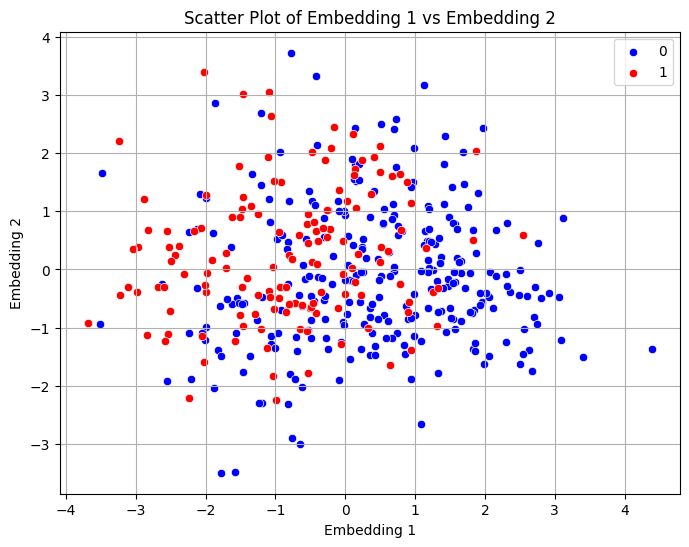

In [ ]:
pca_train_embeddings_df = pd.DataFrame(pca_train_embeddings)
pca_train_embeddings_df.rename(columns={0: 'Embedding 1', 1: 'Embedding 2'}, inplace=True)
pca_train_embeddings_df['Outcome'] = y_train.tolist()

dispScatterPlot(pca_train_embeddings_df)

In [ ]:
# Save pca_train_embeddings_df as json

# Group the DataFrame by 'Outcome' column
grouped = pca_train_embeddings_df.groupby('Outcome')

# Create a dictionary to store the JSON structure
json_data = {}

# Loop through the groups and convert them to JSON structure
for outcome, group in grouped:
    json_data[outcome] = [{'x': x, 'y': y} for x, y in zip(group['Embedding 1'], group['Embedding 2'])]

# Write the JSON data to a file
with open('train_embeddings.json', 'w') as outfile:
    json.dump(json_data, outfile)

### Scatter Plot of train data with a test instance

In [ ]:
pca_test_embedding_instance = pca_test_embeddings[TEST_INSTANCE_IDX:TEST_INSTANCE_IDX+1]

# append prediction
test_row = np.append(pca_test_embedding_instance, round(test_instance_pred))
test_row_df = pd.DataFrame(data=test_row.reshape(1, -1), columns=pca_train_embeddings_df.columns)

# create final dataframe
pca_train_embeddings_with_test_df = pd.concat([pca_train_embeddings_df, test_row_df], ignore_index=True)

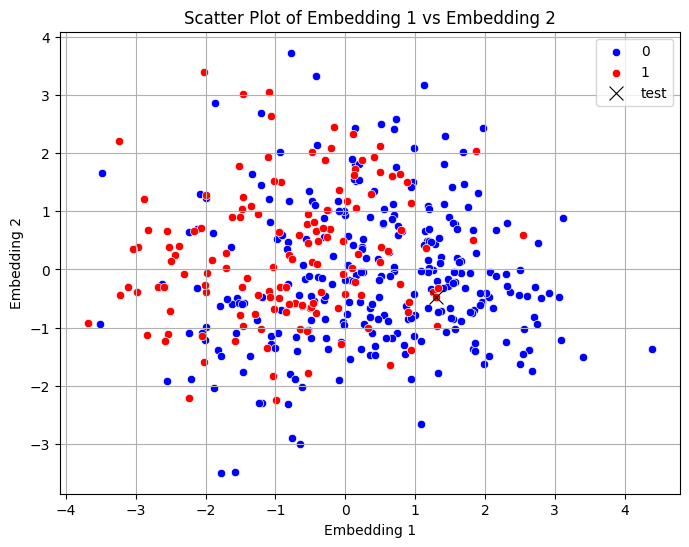

In [ ]:
dispScatterPlot(pca_train_embeddings_with_test_df, has_test=True)